In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Activation, Conv1D, Dot, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carga de los datos

In [2]:
X1 = np.load('../../Data/X1_onehot_1.npy')
X2 = np.load('../../Data/X2_onehot_1.npy')
Y = np.load('../../Data/Y_1.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

print(X1.shape)
print(X2.shape)
print(Y.shape)

(500000, 1, 904)
(500000, 1, 904)
(500000, 1)


In [3]:
val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


# Definicion del modelo

In [4]:
item_input = Input(shape=(X1.shape[1:]), name='item_onehot_encoded')
x_embbeding = Conv1D(16, 3, activation='relu', padding="same")(item_input)
x_embbeding = MaxPooling1D(2, padding='same')(x_embbeding)
x_embbeding = Conv1D(32, 3, activation='relu', padding='same')(x_embbeding)
x_embbeding = MaxPooling1D(2, padding='same')(x_embbeding)
x_embbeding = Flatten()(x_embbeding)
x_embbeding = Dense(64,activation = 'sigmoid')(x_embbeding)

embedding_network = Model(item_input, x_embbeding, name = 'embedding_network')

embedding_network.summary()

Model: "embedding_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_onehot_encoded (InputLa [(None, 1, 904)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 16)             43408     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)          

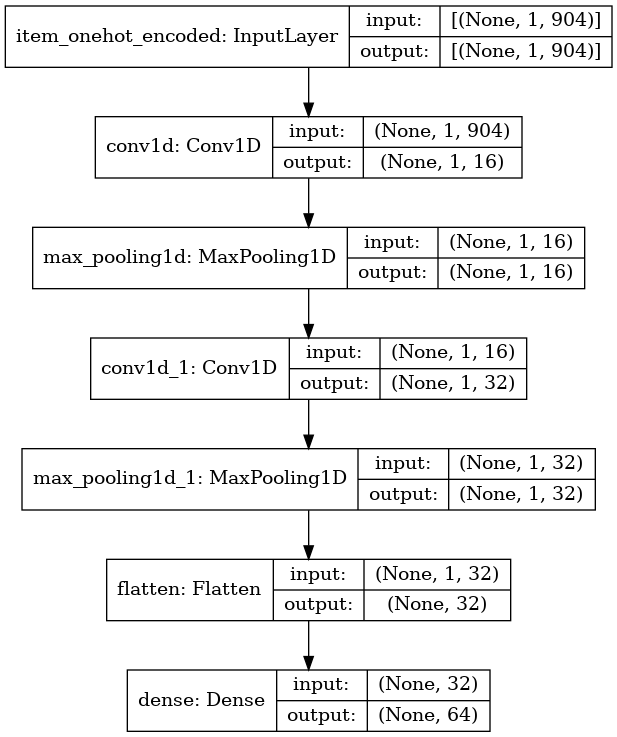

In [5]:
keras.utils.plot_model(embedding_network, show_shapes=True)

In [6]:
input_1 = Input(shape=X1.shape[1:])
input_2 = Input(shape=X2.shape[1:])

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = Dot(name = 'dot_product', axes = 1)([tower_1, tower_2])

output_layer = Dense(1, name='result', activation="sigmoid")(merge_layer)

siamese_network = Model(inputs=[input_1, input_2], outputs=output_layer, name = 'siamese_network')

siamese_network.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 904)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 904)]     0                                            
__________________________________________________________________________________________________
embedding_network (Model)       (None, 64)           47088       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot_product (Dot)               (None, 1)            0           embedding_network[1

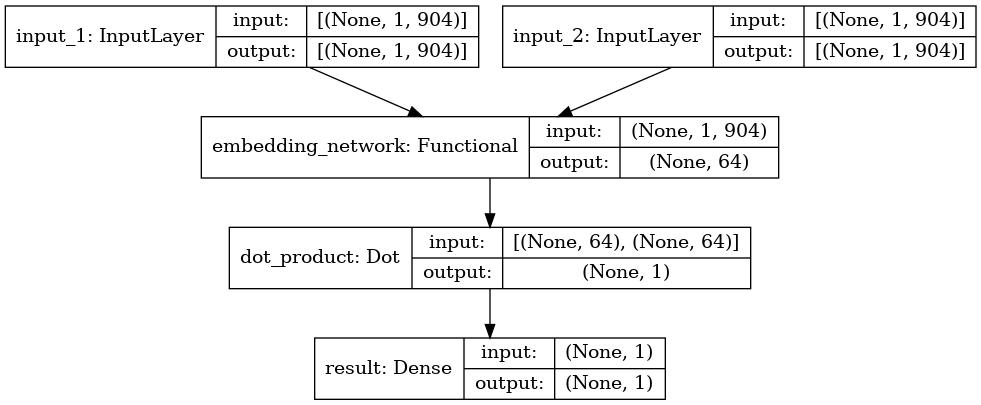

In [7]:
keras.utils.plot_model(siamese_network, show_shapes=True)

In [7]:
METRICS = [
    Recall(name='recall'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision')
]

siamese_network.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = 'binary_crossentropy',
    metrics = METRICS)

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=3)

In [9]:
epochs = 100
batch_size = 32

history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 55s 121us/sample - loss: 0.4655 - recall: 0.8271 - accuracy: 0.7876 - precision: 0.7662 - val_loss: 0.3954 - val_recall: 0.8588 - val_accuracy: 0.8243 - val_precision: 0.8032
Epoch 2/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3805 - recall: 0.8777 - accuracy: 0.8339 - precision: 0.8068 - val_loss: 0.3784 - val_recall: 0.8932 - val_accuracy: 0.8333 - val_precision: 0.7976
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3636 - recall: 0.8824 - accuracy: 0.8427 - precision: 0.8173 - val_loss: 0.3629 - val_recall: 0.9000 - val_accuracy: 0.8415 - val_precision: 0.8057
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3533 - recall: 0.8855 - accuracy: 0.8483 - precision: 0.8240 - val_loss: 0.3572 - val_recall: 0.8926 - val_accuracy: 0.8448 - val_precision: 0.8147
Epoch

In [10]:
def plot_history(history):
    
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    
    axs[0, 0].plot(history.history['loss'],label='Train loss')
    axs[0, 0].plot(history.history['val_loss'],label='Val loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid()

    axs[0, 1].plot(history.history['accuracy'],label='Train accuracy')
    axs[0, 1].plot(history.history['val_accuracy'],label='Val accuracy')
    axs[0, 1].axis(ymin=0,ymax=1)
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid()

    axs[1, 0].plot(history.history['precision'],label='Train precision')
    axs[1, 0].plot(history.history['val_precision'],label='Val precision')
    axs[1, 0].axis(ymin=0,ymax=1)
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()
    axs[1, 0].grid()

    axs[1, 1].plot(history.history['recall'],label='Train recall')
    axs[1, 1].plot(history.history['val_recall'],label='Val recall')
    axs[1, 1].axis(ymin=0,ymax=1)
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()
    axs[1, 1].grid()


In [11]:
embedding_network.save('item2vec_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: item2vec_model\assets


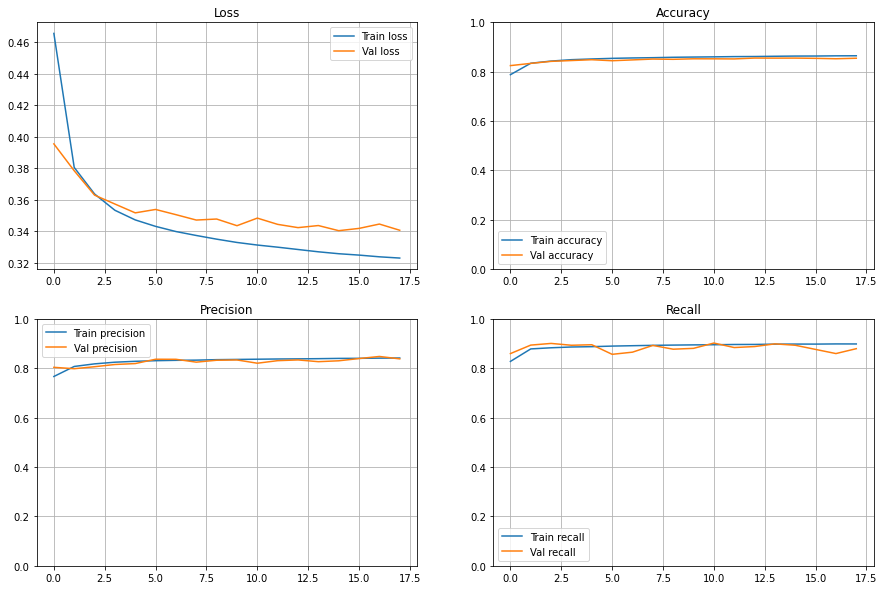

In [12]:
plot_history(history)

# Continuacion del entrenamiento con las otros datos

## Parte 2

In [13]:
X1 = np.load('../../Data/X1_onehot_2.npy')
X2 = np.load('../../Data/X2_onehot_2.npy')
Y = np.load('../../Data/Y_2.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [14]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 117us/sample - loss: 0.3396 - recall: 0.8914 - accuracy: 0.8550 - precision: 0.8313 - val_loss: 0.3371 - val_recall: 0.9088 - val_accuracy: 0.8582 - val_precision: 0.8255
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3336 - recall: 0.8949 - accuracy: 0.8588 - precision: 0.8350 - val_loss: 0.3360 - val_recall: 0.9045 - val_accuracy: 0.8570 - val_precision: 0.8264
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3306 - recall: 0.8950 - accuracy: 0.8597 - precision: 0.8363 - val_loss: 0.3346 - val_recall: 0.8967 - val_accuracy: 0.8590 - val_precision: 0.8342
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3281 - recall: 0.8962 - accuracy: 0.8609 - precision: 0.8375 - val_loss: 0.3338 - val_recall: 0.8960 - val_accuracy: 0.8580 - val_precision: 0.8330
Epoch

In [15]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


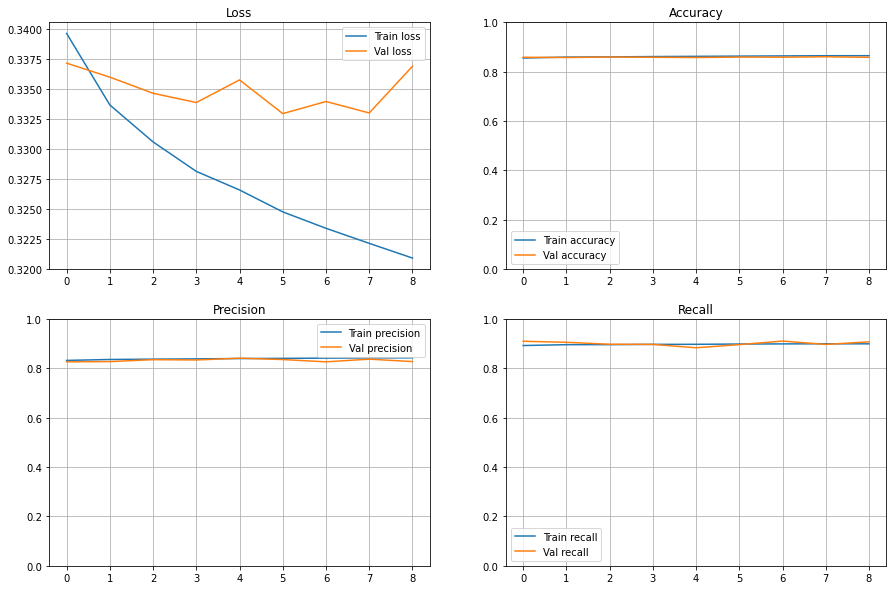

In [16]:
plot_history(history)

## Parte 3

In [17]:
X1 = np.load('../../Data/X1_onehot_3.npy')
X2 = np.load('../../Data/X2_onehot_3.npy')
Y = np.load('../../Data/Y_3.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [18]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3348 - recall: 0.8926 - accuracy: 0.8578 - precision: 0.8344 - val_loss: 0.3362 - val_recall: 0.8860 - val_accuracy: 0.8558 - val_precision: 0.8374
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3297 - recall: 0.8951 - accuracy: 0.8603 - precision: 0.8368 - val_loss: 0.3328 - val_recall: 0.8969 - val_accuracy: 0.8585 - val_precision: 0.8346
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3271 - recall: 0.8966 - accuracy: 0.8616 - precision: 0.8379 - val_loss: 0.3329 - val_recall: 0.8945 - val_accuracy: 0.8583 - val_precision: 0.8358
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3249 - recall: 0.8973 - accuracy: 0.8625 - precision: 0.8389 - val_loss: 0.3338 - val_recall: 0.8841 - val_accuracy: 0.8576 - val_precision: 0.8415
Epoch

In [20]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


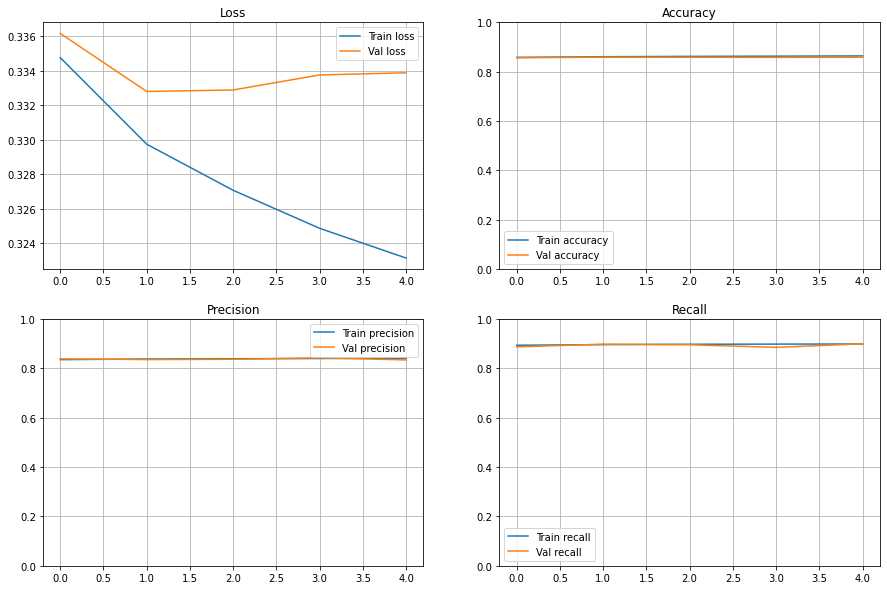

In [21]:
plot_history(history)

## Parte 4

In [22]:
X1 = np.load('../../Data/X1_onehot_4.npy')
X2 = np.load('../../Data/X2_onehot_4.npy')
Y = np.load('../../Data/Y_4.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [23]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3313 - recall: 0.8943 - accuracy: 0.8594 - precision: 0.8357 - val_loss: 0.3389 - val_recall: 0.8862 - val_accuracy: 0.8561 - val_precision: 0.8382
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3262 - recall: 0.8975 - accuracy: 0.8621 - precision: 0.8380 - val_loss: 0.3391 - val_recall: 0.8926 - val_accuracy: 0.8552 - val_precision: 0.8327
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3235 - recall: 0.8978 - accuracy: 0.8631 - precision: 0.8393 - val_loss: 0.3388 - val_recall: 0.8820 - val_accuracy: 0.8550 - val_precision: 0.8392
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3216 - recall: 0.8986 - accuracy: 0.8642 - precision: 0.8405 - val_loss: 0.3396 - val_recall: 0.8795 - val_accuracy: 0.8545 - val_precision: 0.8399
Epoch

In [24]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


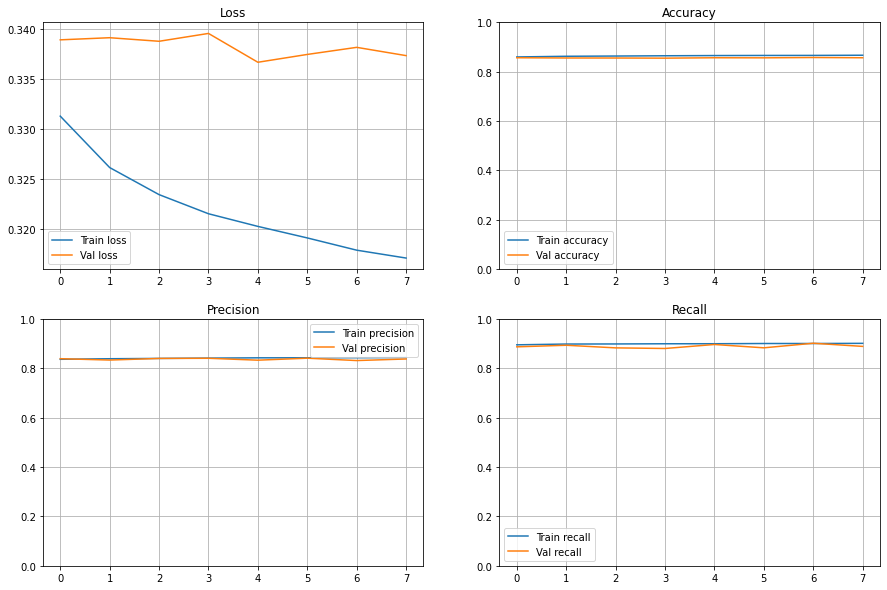

In [25]:
plot_history(history)

## Parte 5

In [26]:
X1 = np.load('../../Data/X1_onehot_5.npy')
X2 = np.load('../../Data/X2_onehot_5.npy')
Y = np.load('../../Data/Y_5.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [27]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3300 - recall: 0.8942 - accuracy: 0.8603 - precision: 0.8371 - val_loss: 0.3323 - val_recall: 0.9002 - val_accuracy: 0.8593 - val_precision: 0.8319
Epoch 2/100
450000/450000 [==============================] - 51s 114us/sample - loss: 0.3251 - recall: 0.8975 - accuracy: 0.8628 - precision: 0.8388 - val_loss: 0.3310 - val_recall: 0.8976 - val_accuracy: 0.8595 - val_precision: 0.8337
Epoch 3/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3226 - recall: 0.8982 - accuracy: 0.8638 - precision: 0.8401 - val_loss: 0.3330 - val_recall: 0.9065 - val_accuracy: 0.8592 - val_precision: 0.8278
Epoch 4/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3208 - recall: 0.8989 - accuracy: 0.8646 - precision: 0.8409 - val_loss: 0.3323 - val_recall: 0.8867 - val_accuracy: 0.8574 - val_precision: 0.8373
Epoch

In [28]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


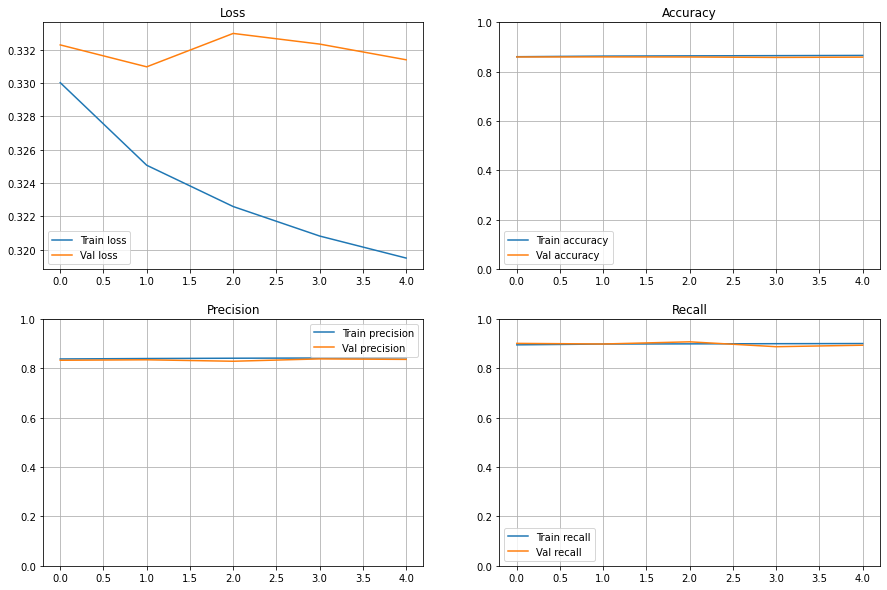

In [29]:
plot_history(history)

## Parte 6

In [30]:
X1 = np.load('../../Data/X1_onehot_6.npy')
X2 = np.load('../../Data/X2_onehot_6.npy')
Y = np.load('../../Data/Y_6.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [31]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3287 - recall: 0.8954 - accuracy: 0.8612 - precision: 0.8381 - val_loss: 0.3235 - val_recall: 0.8944 - val_accuracy: 0.8643 - val_precision: 0.8439
Epoch 2/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3239 - recall: 0.8965 - accuracy: 0.8628 - precision: 0.8399 - val_loss: 0.3234 - val_recall: 0.8893 - val_accuracy: 0.8636 - val_precision: 0.8461
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3215 - recall: 0.8975 - accuracy: 0.8641 - precision: 0.8412 - val_loss: 0.3239 - val_recall: 0.8992 - val_accuracy: 0.8638 - val_precision: 0.8401
Epoch 4/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3199 - recall: 0.8982 - accuracy: 0.8651 - precision: 0.8425 - val_loss: 0.3248 - val_recall: 0.8855 - val_accuracy: 0.8629 - val_precision: 0.8475
Epoch

In [32]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


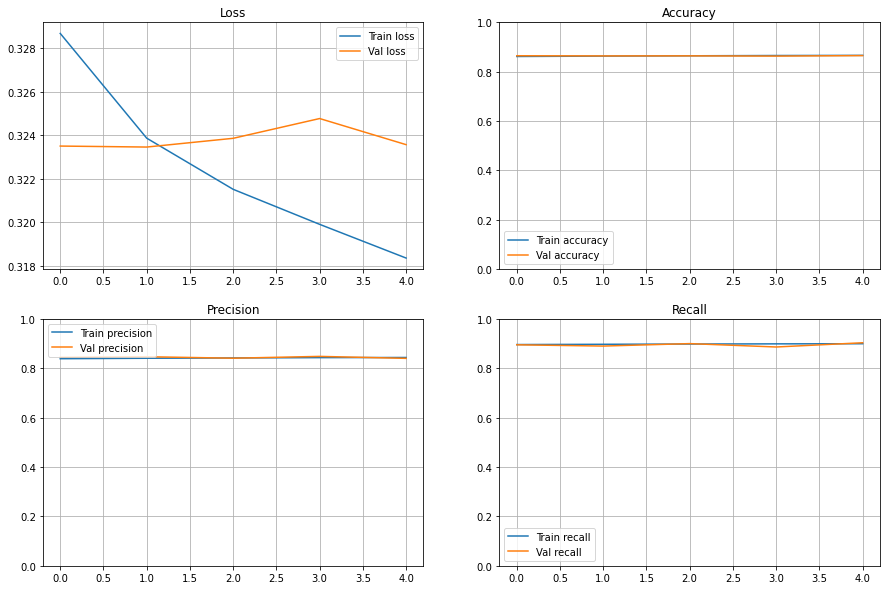

In [33]:
plot_history(history)

## Parte 7

In [34]:
X1 = np.load('../../Data/X1_onehot_7.npy')
X2 = np.load('../../Data/X2_onehot_7.npy')
Y = np.load('../../Data/Y_7.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [35]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3278 - recall: 0.8951 - accuracy: 0.8611 - precision: 0.8381 - val_loss: 0.3287 - val_recall: 0.8935 - val_accuracy: 0.8609 - val_precision: 0.8384
Epoch 2/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3234 - recall: 0.8981 - accuracy: 0.8635 - precision: 0.8400 - val_loss: 0.3296 - val_recall: 0.8942 - val_accuracy: 0.8602 - val_precision: 0.8368
Epoch 3/100
450000/450000 [==============================] - 51s 114us/sample - loss: 0.3212 - recall: 0.8990 - accuracy: 0.8646 - precision: 0.8411 - val_loss: 0.3294 - val_recall: 0.8921 - val_accuracy: 0.8612 - val_precision: 0.8397
Epoch 4/100
450000/450000 [==============================] - 51s 114us/sample - loss: 0.3194 - recall: 0.8999 - accuracy: 0.8655 - precision: 0.8420 - val_loss: 0.3298 - val_recall: 0.8896 - val_accuracy: 0.8610 - val_precision: 0.8410


In [36]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


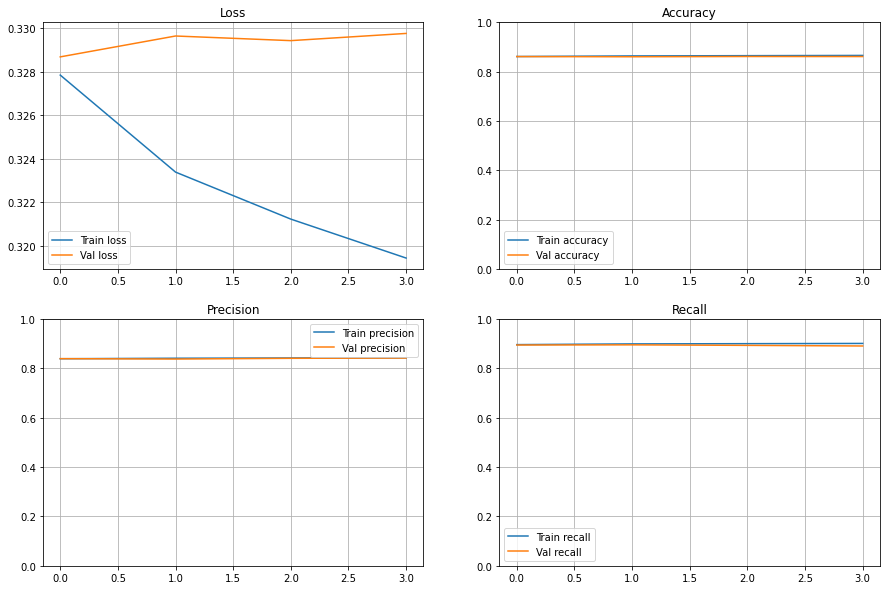

In [37]:
plot_history(history)

## Parte 8

In [38]:
X1 = np.load('../../Data/X1_onehot_8.npy')
X2 = np.load('../../Data/X2_onehot_8.npy')
Y = np.load('../../Data/Y_8.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [39]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3277 - recall: 0.8944 - accuracy: 0.8612 - precision: 0.8382 - val_loss: 0.3297 - val_recall: 0.8895 - val_accuracy: 0.8603 - val_precision: 0.8397
Epoch 2/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3236 - recall: 0.8965 - accuracy: 0.8632 - precision: 0.8399 - val_loss: 0.3292 - val_recall: 0.8953 - val_accuracy: 0.8612 - val_precision: 0.8375
Epoch 3/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3213 - recall: 0.8976 - accuracy: 0.8645 - precision: 0.8413 - val_loss: 0.3293 - val_recall: 0.8854 - val_accuracy: 0.8615 - val_precision: 0.8444
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3196 - recall: 0.8981 - accuracy: 0.8654 - precision: 0.8424 - val_loss: 0.3303 - val_recall: 0.8961 - val_accuracy: 0.8604 - val_precision: 0.8357
Epoch

In [40]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


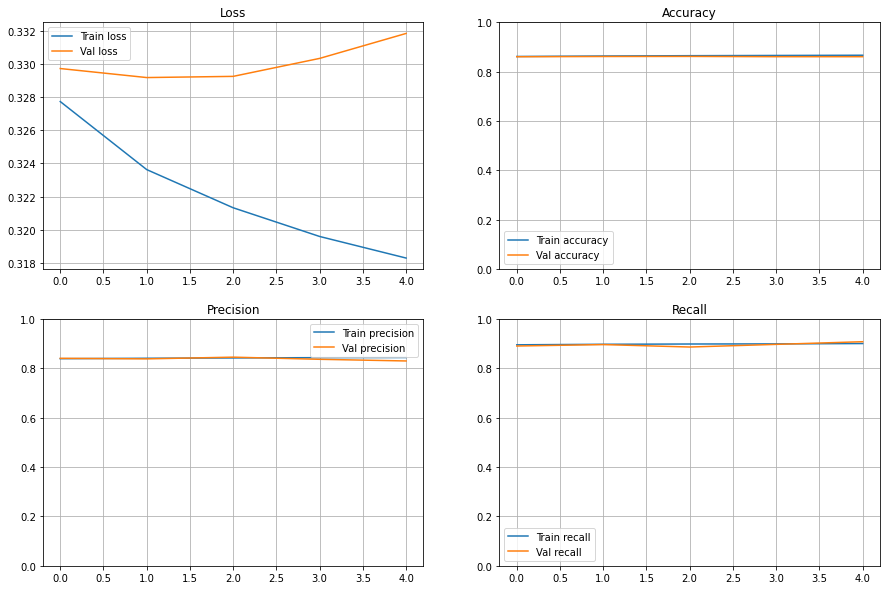

In [41]:
plot_history(history)

## Parte 9

In [42]:
X1 = np.load('../../Data/X1_onehot_9.npy')
X2 = np.load('../../Data/X2_onehot_9.npy')
Y = np.load('../../Data/Y_9.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [43]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3260 - recall: 0.8965 - accuracy: 0.8623 - precision: 0.8396 - val_loss: 0.3316 - val_recall: 0.8775 - val_accuracy: 0.8589 - val_precision: 0.8464
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3216 - recall: 0.8988 - accuracy: 0.8649 - precision: 0.8421 - val_loss: 0.3296 - val_recall: 0.8986 - val_accuracy: 0.8604 - val_precision: 0.8351
Epoch 3/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3194 - recall: 0.8997 - accuracy: 0.8656 - precision: 0.8427 - val_loss: 0.3309 - val_recall: 0.8842 - val_accuracy: 0.8597 - val_precision: 0.8432
Epoch 4/100
450000/450000 [==============================] - 52s 115us/sample - loss: 0.3179 - recall: 0.8999 - accuracy: 0.8664 - precision: 0.8438 - val_loss: 0.3300 - val_recall: 0.9015 - val_accuracy: 0.8617 - val_precision: 0.8353
Epoch

In [44]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


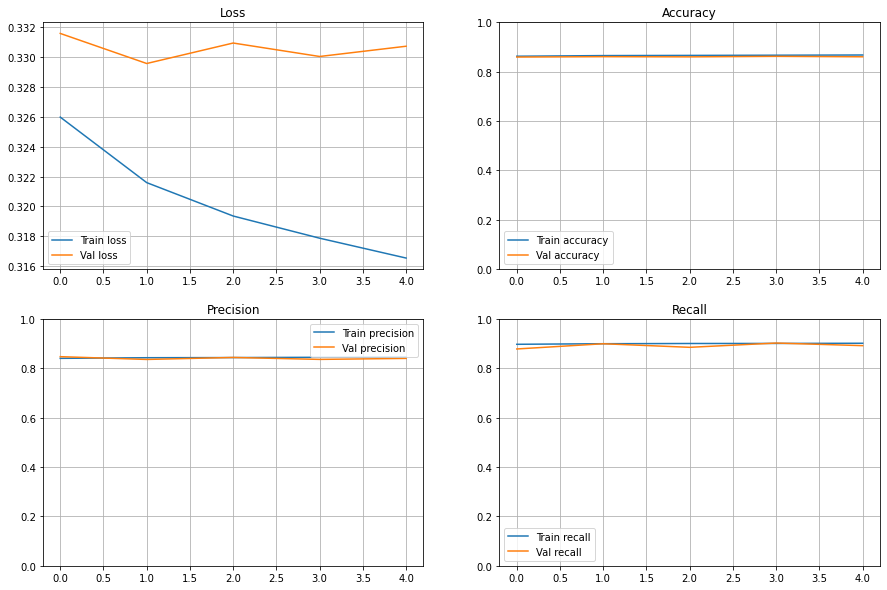

In [45]:
plot_history(history)

## Parte 10

In [46]:
X1 = np.load('../../Data/X1_onehot_10.npy')
X2 = np.load('../../Data/X2_onehot_10.npy')
Y = np.load('../../Data/Y_10.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [47]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 117us/sample - loss: 0.3155 - recall: 0.9012 - accuracy: 0.8672 - precision: 0.8443 - val_loss: 0.3318 - val_recall: 0.8758 - val_accuracy: 0.8591 - val_precision: 0.8478
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3145 - recall: 0.9014 - accuracy: 0.8681 - precision: 0.8456 - val_loss: 0.3309 - val_recall: 0.8934 - val_accuracy: 0.8605 - val_precision: 0.8385
Epoch 3/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3136 - recall: 0.9015 - accuracy: 0.8686 - precision: 0.8463 - val_loss: 0.3311 - val_recall: 0.8956 - val_accuracy: 0.8610 - val_precision: 0.8378
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3132 - recall: 0.9022 - accuracy: 0.8686 - precision: 0.8459 - val_loss: 0.3324 - val_recall: 0.9015 - val_accuracy: 0.8598 - val_precision: 0.8324
Epoch

In [48]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


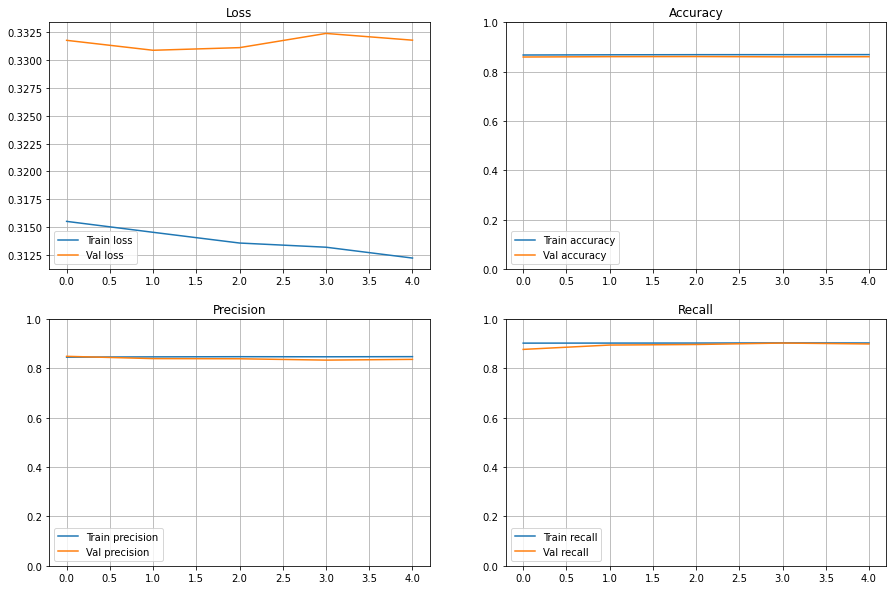

In [49]:
plot_history(history)

## Parte 11

In [50]:
X1 = np.load('../../Data/X1_onehot_11.npy')
X2 = np.load('../../Data/X2_onehot_11.npy')
Y = np.load('../../Data/Y_11.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [51]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3273 - recall: 0.8941 - accuracy: 0.8614 - precision: 0.8392 - val_loss: 0.3245 - val_recall: 0.8988 - val_accuracy: 0.8630 - val_precision: 0.8386
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3229 - recall: 0.8971 - accuracy: 0.8635 - precision: 0.8406 - val_loss: 0.3246 - val_recall: 0.8933 - val_accuracy: 0.8626 - val_precision: 0.8414
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3205 - recall: 0.8986 - accuracy: 0.8650 - precision: 0.8420 - val_loss: 0.3248 - val_recall: 0.9006 - val_accuracy: 0.8631 - val_precision: 0.8376
Epoch 4/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3190 - recall: 0.8991 - accuracy: 0.8656 - precision: 0.8426 - val_loss: 0.3267 - val_recall: 0.8803 - val_accuracy: 0.8605 - val_precision: 0.8466


In [52]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


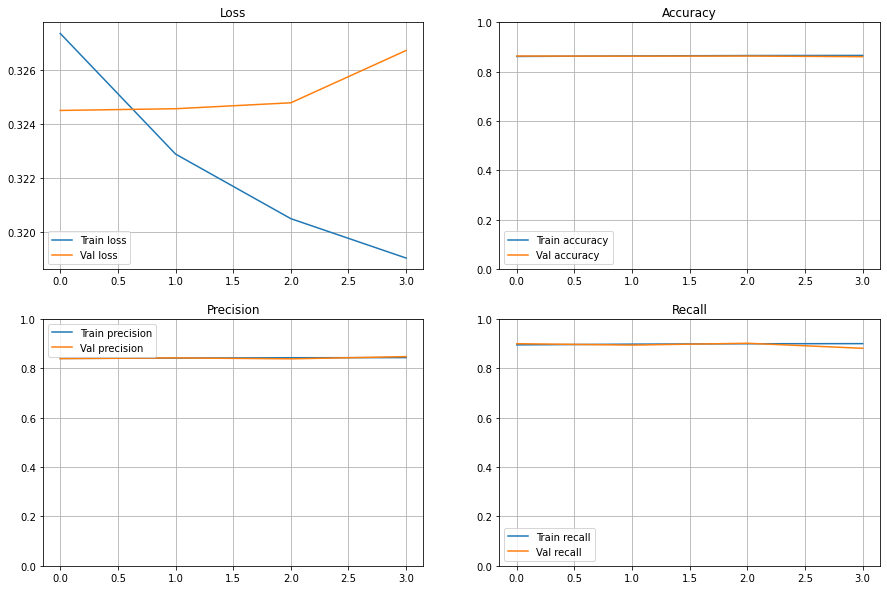

In [53]:
plot_history(history)

## Parte 12

In [54]:
X1 = np.load('../../Data/X1_onehot_12.npy')
X2 = np.load('../../Data/X2_onehot_12.npy')
Y = np.load('../../Data/Y_12.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [55]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3229 - recall: 0.8976 - accuracy: 0.8645 - precision: 0.8417 - val_loss: 0.3273 - val_recall: 0.9010 - val_accuracy: 0.8627 - val_precision: 0.8384
Epoch 2/100
450000/450000 [==============================] - 57s 127us/sample - loss: 0.3188 - recall: 0.8990 - accuracy: 0.8662 - precision: 0.8434 - val_loss: 0.3284 - val_recall: 0.8926 - val_accuracy: 0.8614 - val_precision: 0.8418
Epoch 3/100
450000/450000 [==============================] - 54s 120us/sample - loss: 0.3164 - recall: 0.9008 - accuracy: 0.8677 - precision: 0.8447 - val_loss: 0.3273 - val_recall: 0.8885 - val_accuracy: 0.8606 - val_precision: 0.8432
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3149 - recall: 0.9005 - accuracy: 0.8682 - precision: 0.8457 - val_loss: 0.3285 - val_recall: 0.8841 - val_accuracy: 0.8602 - val_precision: 0.8453


In [56]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


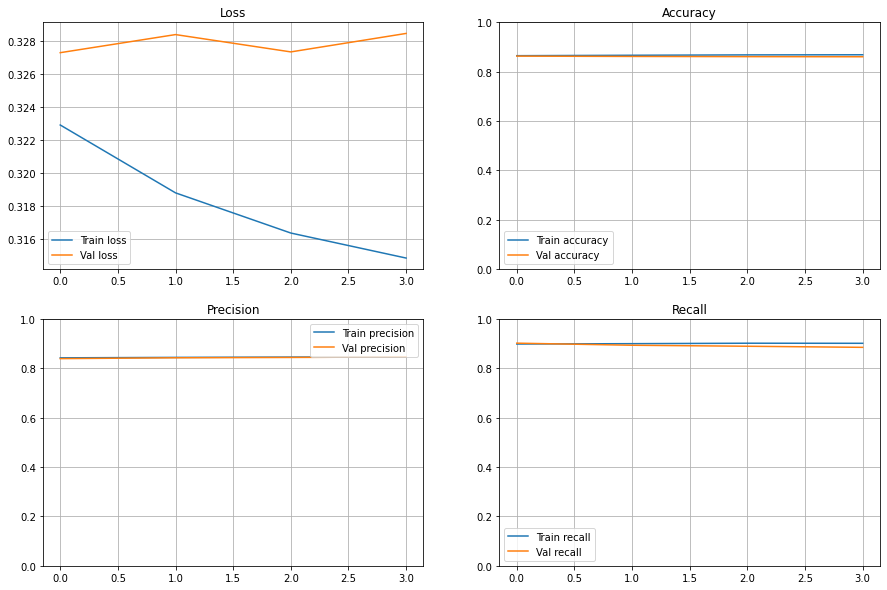

In [57]:
plot_history(history)

## Parte 13

In [58]:
X1 = np.load('../../Data/X1_onehot_13.npy')
X2 = np.load('../../Data/X2_onehot_13.npy')
Y = np.load('../../Data/Y_13.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [59]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 52s 117us/sample - loss: 0.3246 - recall: 0.8971 - accuracy: 0.8634 - precision: 0.8407 - val_loss: 0.3301 - val_recall: 0.8884 - val_accuracy: 0.8598 - val_precision: 0.8409
Epoch 2/100
450000/450000 [==============================] - 52s 116us/sample - loss: 0.3208 - recall: 0.8993 - accuracy: 0.8653 - precision: 0.8422 - val_loss: 0.3311 - val_recall: 0.9064 - val_accuracy: 0.8601 - val_precision: 0.8302
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3184 - recall: 0.9014 - accuracy: 0.8673 - precision: 0.8440 - val_loss: 0.3316 - val_recall: 0.9100 - val_accuracy: 0.8595 - val_precision: 0.8271
Epoch 4/100
450000/450000 [==============================] - 53s 118us/sample - loss: 0.3169 - recall: 0.9008 - accuracy: 0.8671 - precision: 0.8441 - val_loss: 0.3298 - val_recall: 0.8977 - val_accuracy: 0.8599 - val_precision: 0.8352
Epoch

In [60]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


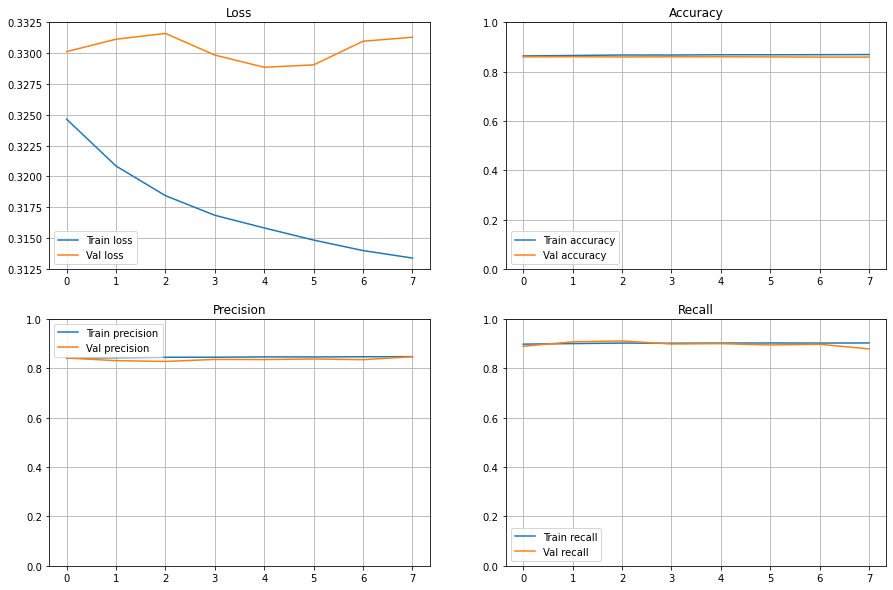

In [61]:
plot_history(history)

## Parte 14

In [62]:
X1 = np.load('../../Data/X1_onehot_14.npy')
X2 = np.load('../../Data/X2_onehot_14.npy')
Y = np.load('../../Data/Y_14.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [63]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3249 - recall: 0.8963 - accuracy: 0.8632 - precision: 0.8408 - val_loss: 0.3274 - val_recall: 0.9114 - val_accuracy: 0.8631 - val_precision: 0.8329
Epoch 2/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3204 - recall: 0.8989 - accuracy: 0.8656 - precision: 0.8429 - val_loss: 0.3256 - val_recall: 0.9059 - val_accuracy: 0.8629 - val_precision: 0.8359
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3182 - recall: 0.9000 - accuracy: 0.8668 - precision: 0.8441 - val_loss: 0.3235 - val_recall: 0.9010 - val_accuracy: 0.8641 - val_precision: 0.8408
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3166 - recall: 0.9006 - accuracy: 0.8678 - precision: 0.8453 - val_loss: 0.3240 - val_recall: 0.8907 - val_accuracy: 0.8630 - val_precision: 0.8457
Epoch

In [64]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


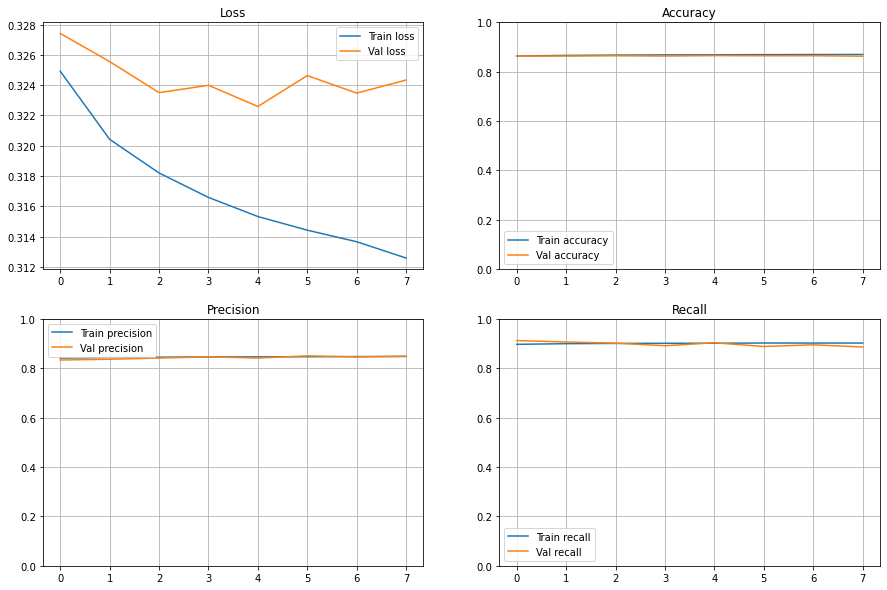

In [65]:
plot_history(history)

## Parte 15

In [66]:
X1 = np.load('../../Data/X1_onehot_15.npy')
X2 = np.load('../../Data/X2_onehot_15.npy')
Y = np.load('../../Data/Y_15.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [67]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3247 - recall: 0.8957 - accuracy: 0.8631 - precision: 0.8403 - val_loss: 0.3255 - val_recall: 0.9044 - val_accuracy: 0.8634 - val_precision: 0.8364
Epoch 2/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3207 - recall: 0.8990 - accuracy: 0.8655 - precision: 0.8420 - val_loss: 0.3266 - val_recall: 0.8855 - val_accuracy: 0.8625 - val_precision: 0.8471
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3186 - recall: 0.8991 - accuracy: 0.8662 - precision: 0.8432 - val_loss: 0.3257 - val_recall: 0.8934 - val_accuracy: 0.8635 - val_precision: 0.8436
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3170 - recall: 0.9006 - accuracy: 0.8673 - precision: 0.8438 - val_loss: 0.3260 - val_recall: 0.9040 - val_accuracy: 0.8638 - val_precision: 0.8374


In [68]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


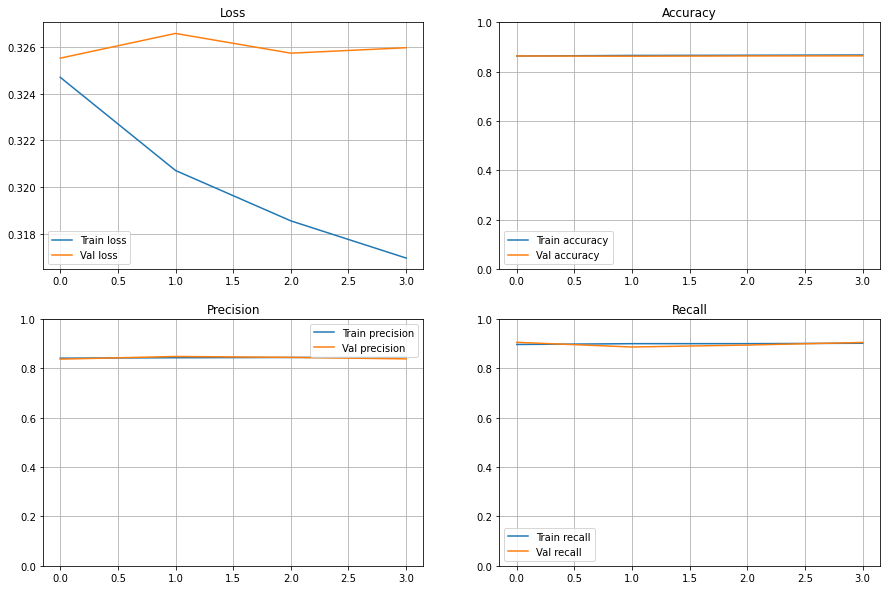

In [69]:
plot_history(history)

## Parte 16

In [70]:
X1 = np.load('../../Data/X1_onehot_16.npy')
X2 = np.load('../../Data/X2_onehot_16.npy')
Y = np.load('../../Data/Y_16.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [71]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3240 - recall: 0.8969 - accuracy: 0.8635 - precision: 0.8412 - val_loss: 0.3183 - val_recall: 0.9041 - val_accuracy: 0.8659 - val_precision: 0.8399
Epoch 2/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3201 - recall: 0.8991 - accuracy: 0.8653 - precision: 0.8427 - val_loss: 0.3183 - val_recall: 0.9040 - val_accuracy: 0.8660 - val_precision: 0.8402
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3180 - recall: 0.9001 - accuracy: 0.8664 - precision: 0.8437 - val_loss: 0.3192 - val_recall: 0.8929 - val_accuracy: 0.8650 - val_precision: 0.8457
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3166 - recall: 0.9002 - accuracy: 0.8669 - precision: 0.8445 - val_loss: 0.3188 - val_recall: 0.9138 - val_accuracy: 0.8658 - val_precision: 0.8338


In [72]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


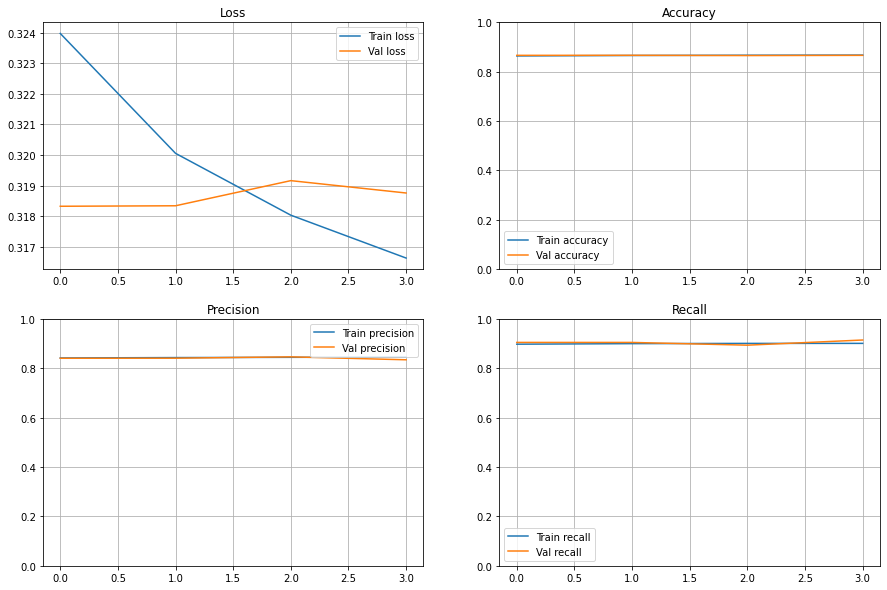

In [73]:
plot_history(history)

## Parte 17

In [74]:
X1 = np.load('../../Data/X1_onehot_17.npy')
X2 = np.load('../../Data/X2_onehot_17.npy')
Y = np.load('../../Data/Y_17.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [75]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3245 - recall: 0.8973 - accuracy: 0.8637 - precision: 0.8407 - val_loss: 0.3211 - val_recall: 0.9012 - val_accuracy: 0.8665 - val_precision: 0.8429
Epoch 2/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3207 - recall: 0.8988 - accuracy: 0.8658 - precision: 0.8430 - val_loss: 0.3205 - val_recall: 0.9036 - val_accuracy: 0.8662 - val_precision: 0.8410
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3186 - recall: 0.9001 - accuracy: 0.8667 - precision: 0.8436 - val_loss: 0.3216 - val_recall: 0.8940 - val_accuracy: 0.8648 - val_precision: 0.8450
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3172 - recall: 0.9005 - accuracy: 0.8673 - precision: 0.8444 - val_loss: 0.3212 - val_recall: 0.9042 - val_accuracy: 0.8648 - val_precision: 0.8385
Epoch

In [76]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


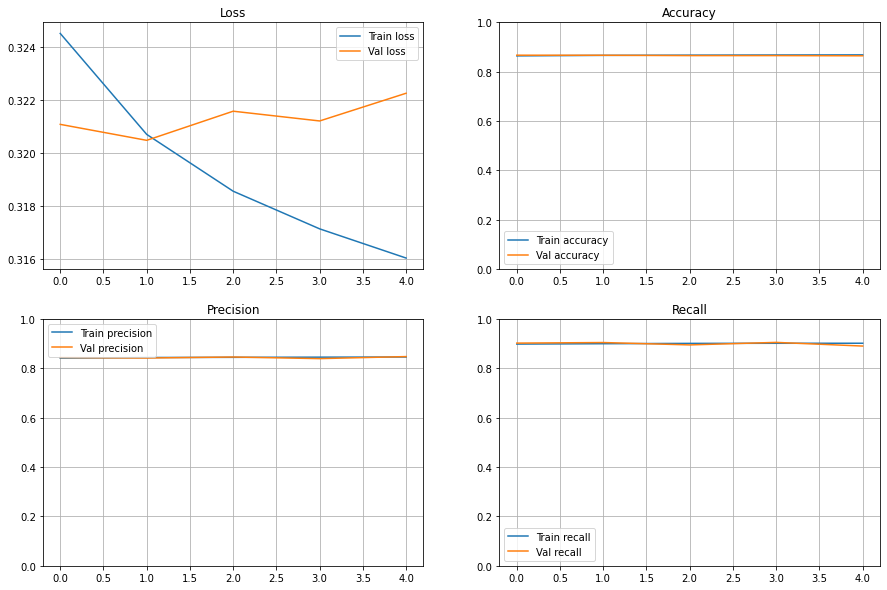

In [77]:
plot_history(history)

## Parte 18

In [78]:
X1 = np.load('../../Data/X1_onehot_18.npy')
X2 = np.load('../../Data/X2_onehot_18.npy')
Y = np.load('../../Data/Y_18.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(450000, 1, 904)
X2 train:
(450000, 1, 904)
Y train:
(450000, 1)
X1 val:
(50000, 1, 904)
X2 val:
(50000, 1, 904)
Y val:
(50000, 1)


In [79]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3258 - recall: 0.8970 - accuracy: 0.8632 - precision: 0.8398 - val_loss: 0.3242 - val_recall: 0.8991 - val_accuracy: 0.8639 - val_precision: 0.8398
Epoch 2/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3220 - recall: 0.8986 - accuracy: 0.8650 - precision: 0.8417 - val_loss: 0.3245 - val_recall: 0.8912 - val_accuracy: 0.8613 - val_precision: 0.8407
Epoch 3/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3200 - recall: 0.9002 - accuracy: 0.8661 - precision: 0.8423 - val_loss: 0.3257 - val_recall: 0.8996 - val_accuracy: 0.8628 - val_precision: 0.8377
Epoch 4/100
450000/450000 [==============================] - 53s 117us/sample - loss: 0.3187 - recall: 0.9002 - accuracy: 0.8666 - precision: 0.8431 - val_loss: 0.3238 - val_recall: 0.8928 - val_accuracy: 0.8627 - val_precision: 0.8418
Epoch

In [80]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


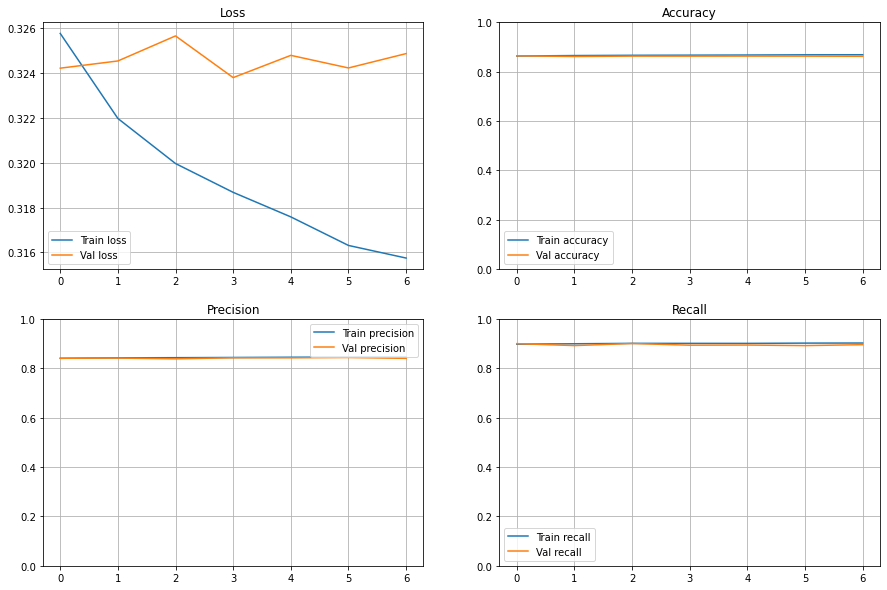

In [81]:
plot_history(history)

## Parte 19

In [82]:
X1 = np.load('../../Data/X1_onehot_19.npy')
X2 = np.load('../../Data/X2_onehot_19.npy')
Y = np.load('../../Data/Y_19.npy')

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

val_size = int(X1.shape[0]*0.1) #10%

X1_train = X1[:-val_size,:]
X1_val = X1[-val_size:,:]

X2_train = X2[:-val_size,:]
X2_val = X2[-val_size:,:]

Y_train = Y[:-val_size,:]
Y_val = Y[-val_size:,:]

print('X1 train:')
print(X1_train.shape)
print('X2 train:')
print(X2_train.shape)
print('Y train:')
print(Y_train.shape)

print('X1 val:')
print(X1_val.shape)
print('X2 val:')
print(X2_val.shape)
print('Y val:')
print(Y_val.shape)

X1 train:
(24531, 1, 904)
X2 train:
(24531, 1, 904)
Y train:
(24531, 1)
X1 val:
(2725, 1, 904)
X2 val:
(2725, 1, 904)
Y val:
(2725, 1)


In [83]:
history = siamese_network.fit([X1_train, X2_train], Y_train, validation_data = ([X1_val, X2_val], Y_val), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Train on 24531 samples, validate on 2725 samples
Epoch 1/100
24531/24531 [==============================] - 3s 124us/sample - loss: 0.3307 - recall: 0.8897 - accuracy: 0.8580 - precision: 0.8344 - val_loss: 0.3165 - val_recall: 0.8912 - val_accuracy: 0.8683 - val_precision: 0.8531
Epoch 2/100
24531/24531 [==============================] - 3s 118us/sample - loss: 0.3173 - recall: 0.8993 - accuracy: 0.8658 - precision: 0.8408 - val_loss: 0.3183 - val_recall: 0.8809 - val_accuracy: 0.8675 - val_precision: 0.8590
Epoch 3/100
24531/24531 [==============================] - 3s 118us/sample - loss: 0.3088 - recall: 0.9062 - accuracy: 0.8714 - precision: 0.8452 - val_loss: 0.3197 - val_recall: 0.8904 - val_accuracy: 0.8639 - val_precision: 0.8465
Epoch 4/100
24531/24531 [==============================] - 3s 119us/sample - loss: 0.3013 - recall: 0.9094 - accuracy: 0.8742 - precision: 0.8475 - val_loss: 0.3202 - val_recall: 0.8875 - val_accuracy: 0.8631 - val_precision: 0.8473


In [84]:
embedding_network.save('item2vec_model')

INFO:tensorflow:Assets written to: item2vec_model\assets


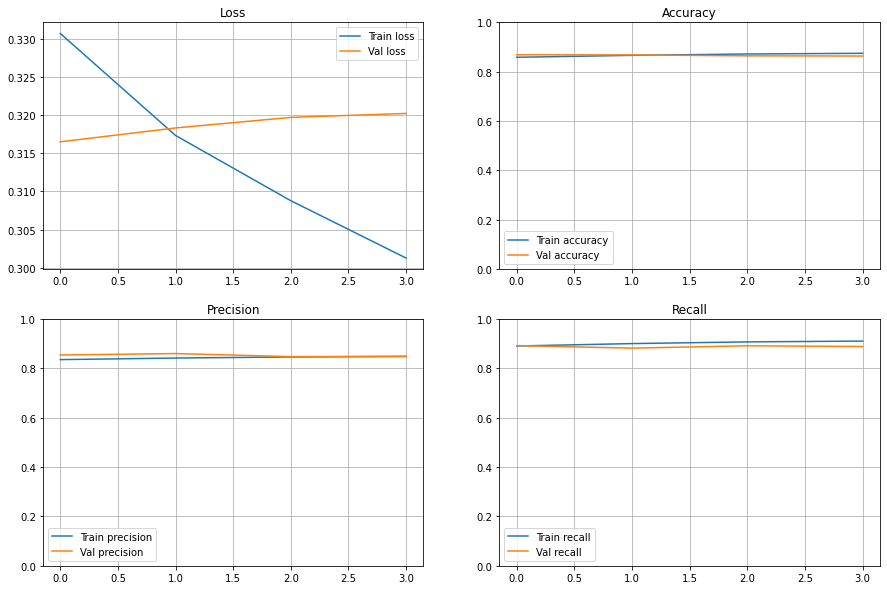

In [85]:
plot_history(history)

# Codificacion de los items a espacio latente

In [86]:
items_onehot_encoded_df = pd.read_csv('../../Data/items_onehot_encoded.csv')
items_onehot_encoded_df

,item_id,1_60,1_143,1_358,1_461,1_517,1_771,2_53,2_56,2_83,...,72_665,72_671,72_712,72_747,72_748,72_751,72_829,72_883,73_91,73_544
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,28139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23687,28140,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
23688,28141,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23689,28142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [87]:
X = items_onehot_encoded_df.drop('item_id', axis=1).to_numpy()
X.shape

(23691, 904)

In [88]:
X = np.expand_dims(X, axis=1)
X.shape

(23691, 1, 904)

In [92]:
X = X.astype('float32')

In [93]:
encoded_items = embedding_network(X)
encoded_items.shape

TensorShape([23691, 64])

In [94]:
encoded_items_df = pd.DataFrame(encoded_items.numpy())
encoded_items_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000e+00,0.000000e+00,8.259485e-38,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,1.147872e-04,1.196613e-25,0.000000,0.000000e+00,4.975298e-21,0.000000,1.000000e+00,1.283712e-37,0.000000e+00,5.708601e-11
1,7.226150e-16,2.417073e-01,2.325430e-14,3.434116e-10,9.999779e-01,2.084914e-19,2.359839e-04,7.360519e-18,3.367935e-12,9.998788e-01,...,6.631301e-28,1.442925e-15,1.000000,7.131817e-04,9.999999e-01,0.034609,8.714515e-01,5.728165e-07,1.033759e-04,9.978011e-01
2,7.434463e-30,7.750213e-18,0.000000e+00,1.445317e-29,1.000000e+00,0.000000e+00,0.000000e+00,3.267208e-25,9.452282e-33,2.389837e-19,...,0.000000e+00,5.438013e-28,1.000000,5.429324e-03,1.000000e+00,1.000000,9.924654e-01,6.889178e-05,9.211239e-23,2.146675e-14
3,5.490076e-37,0.000000e+00,1.191505e-21,9.322182e-12,4.260253e-13,5.699080e-01,1.000000e+00,4.086731e-30,5.050279e-12,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000,1.472102e-12,4.147344e-34,0.000000,0.000000e+00,1.565254e-36,1.000000e+00,1.000000e+00
4,2.423661e-25,2.795917e-11,6.869838e-35,1.957358e-24,1.000000e+00,1.214310e-37,0.000000e+00,2.739703e-17,1.734631e-19,1.702003e-14,...,0.000000e+00,1.350020e-19,1.000000,7.157927e-10,1.000000e+00,1.000000,2.604076e-02,1.155714e-02,3.667003e-09,1.811880e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,9.726211e-01,2.284531e-11,2.776817e-11,5.597994e-02,1.026659e-02,2.461190e-02,1.000000e+00,3.444717e-18,1.398369e-05,9.999964e-01,...,4.171538e-03,1.981965e-04,0.961271,7.362516e-17,3.345782e-01,0.000326,3.236383e-25,6.360826e-16,9.999509e-01,9.999608e-01
23687,9.997767e-01,2.538743e-08,7.991548e-11,2.896282e-21,3.695540e-04,9.091385e-18,2.061393e-09,1.558076e-14,5.036157e-05,4.009711e-01,...,3.120203e-29,1.000000e+00,1.000000,2.877177e-09,2.796884e-04,0.615862,9.811885e-01,1.042302e-14,2.447064e-09,9.952277e-01
23688,2.941844e-15,7.376524e-11,3.965194e-17,8.104620e-05,9.995428e-01,5.364074e-11,4.411794e-07,4.666649e-08,1.239170e-11,9.999754e-01,...,2.487879e-37,3.125461e-19,1.000000,4.307819e-08,1.000000e+00,0.987323,9.997515e-01,3.231752e-02,1.217761e-02,8.776583e-06
23689,0.000000e+00,1.112993e-36,1.000000e+00,1.000000e+00,3.748123e-22,1.000000e+00,1.000000e+00,1.000000e+00,1.470198e-26,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000,5.781284e-18,0.000000e+00,0.000000,6.874122e-17,0.000000e+00,1.000000e+00,5.961677e-13


In [95]:
items_onehot_encoded_df.item_id

0            2
1            3
2            4
3            7
4            8
         ...  
23686    28139
23687    28140
23688    28141
23689    28142
23690    28143
Name: item_id, Length: 23691, dtype: int64

In [96]:
encoded_items_df.insert(loc=0, column='item_id', value=list(items_onehot_encoded_df.item_id))

In [97]:
encoded_items_df

,item_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,2,0.000000e+00,0.000000e+00,8.259485e-38,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,1.147872e-04,1.196613e-25,0.000000,0.000000e+00,4.975298e-21,0.000000,1.000000e+00,1.283712e-37,0.000000e+00,5.708601e-11
1,3,7.226150e-16,2.417073e-01,2.325430e-14,3.434116e-10,9.999779e-01,2.084914e-19,2.359839e-04,7.360519e-18,3.367935e-12,...,6.631301e-28,1.442925e-15,1.000000,7.131817e-04,9.999999e-01,0.034609,8.714515e-01,5.728165e-07,1.033759e-04,9.978011e-01
2,4,7.434463e-30,7.750213e-18,0.000000e+00,1.445317e-29,1.000000e+00,0.000000e+00,0.000000e+00,3.267208e-25,9.452282e-33,...,0.000000e+00,5.438013e-28,1.000000,5.429324e-03,1.000000e+00,1.000000,9.924654e-01,6.889178e-05,9.211239e-23,2.146675e-14
3,7,5.490076e-37,0.000000e+00,1.191505e-21,9.322182e-12,4.260253e-13,5.699080e-01,1.000000e+00,4.086731e-30,5.050279e-12,...,1.000000e+00,0.000000e+00,0.000000,1.472102e-12,4.147344e-34,0.000000,0.000000e+00,1.565254e-36,1.000000e+00,1.000000e+00
4,8,2.423661e-25,2.795917e-11,6.869838e-35,1.957358e-24,1.000000e+00,1.214310e-37,0.000000e+00,2.739703e-17,1.734631e-19,...,0.000000e+00,1.350020e-19,1.000000,7.157927e-10,1.000000e+00,1.000000,2.604076e-02,1.155714e-02,3.667003e-09,1.811880e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,28139,9.726211e-01,2.284531e-11,2.776817e-11,5.597994e-02,1.026659e-02,2.461190e-02,1.000000e+00,3.444717e-18,1.398369e-05,...,4.171538e-03,1.981965e-04,0.961271,7.362516e-17,3.345782e-01,0.000326,3.236383e-25,6.360826e-16,9.999509e-01,9.999608e-01
23687,28140,9.997767e-01,2.538743e-08,7.991548e-11,2.896282e-21,3.695540e-04,9.091385e-18,2.061393e-09,1.558076e-14,5.036157e-05,...,3.120203e-29,1.000000e+00,1.000000,2.877177e-09,2.796884e-04,0.615862,9.811885e-01,1.042302e-14,2.447064e-09,9.952277e-01
23688,28141,2.941844e-15,7.376524e-11,3.965194e-17,8.104620e-05,9.995428e-01,5.364074e-11,4.411794e-07,4.666649e-08,1.239170e-11,...,2.487879e-37,3.125461e-19,1.000000,4.307819e-08,1.000000e+00,0.987323,9.997515e-01,3.231752e-02,1.217761e-02,8.776583e-06
23689,28142,0.000000e+00,1.112993e-36,1.000000e+00,1.000000e+00,3.748123e-22,1.000000e+00,1.000000e+00,1.000000e+00,1.470198e-26,...,1.000000e+00,0.000000e+00,0.000000,5.781284e-18,0.000000e+00,0.000000,6.874122e-17,0.000000e+00,1.000000e+00,5.961677e-13


In [99]:
encoded_items_df.describe()

,item_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
count,23691.000000,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,...,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04,2.369100e+04
mean,14053.882107,1.133543e-01,6.131908e-02,3.014331e-01,4.071366e-01,3.547379e-01,4.788173e-01,5.563288e-01,3.081593e-01,1.172539e-01,...,3.385749e-01,1.510456e-01,3.932283e-01,1.203015e-01,4.364925e-01,2.476418e-01,3.726565e-01,1.215660e-01,3.747905e-01,5.335227e-01
std,8103.749598,3.117046e-01,2.172517e-01,4.495575e-01,4.826288e-01,4.612074e-01,4.946771e-01,4.899452e-01,4.540129e-01,3.073395e-01,...,4.655656e-01,3.516435e-01,4.819942e-01,3.157377e-01,4.837967e-01,4.135291e-01,4.713604e-01,3.131379e-01,4.596128e-01,4.793214e-01
min,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7054.500000,1.458343e-31,5.312039e-29,2.336086e-21,2.394180e-19,8.613291e-18,2.382648e-25,1.059049e-18,2.569648e-25,3.904273e-19,...,9.915586e-33,2.704613e-33,0.000000e+00,7.257462e-17,2.080108e-21,0.000000e+00,2.272448e-16,8.101791e-28,2.813996e-10,1.606094e-08
50%,14061.000000,1.481126e-16,3.958935e-14,6.508190e-09,4.693314e-05,2.541710e-05,1.027232e-02,9.996827e-01,1.057377e-09,1.267681e-10,...,2.013894e-10,3.192392e-15,1.810337e-08,9.241797e-10,3.026410e-03,1.488762e-16,1.174331e-05,6.664023e-14,2.944655e-03,8.599935e-01
75%,21047.500000,1.185635e-07,5.803367e-06,9.983408e-01,1.000000e+00,9.967853e-01,1.000000e+00,1.000000e+00,9.999549e-01,9.615545e-05,...,9.999992e-01,2.644061e-06,1.000000e+00,7.268717e-05,9.999996e-01,4.380893e-01,9.998995e-01,1.252941e-05,9.983868e-01,9.999998e-01
max,28143.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [98]:
encoded_items_df.to_csv('../../Data/items_item2vec_encoded.csv', index=False)